In [1]:
import sys
sys.path.append('/scratch/ne2213/projects/tmp_packages')
sys.path.append('/scratch/ne2213/projects/tmp_packages/')
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import muspy
from torch.utils.data import DataLoader
import pygame

pygame 2.5.2 (SDL 2.28.2, Python 3.8.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# dataloader class
class get_dataloader(object):
    def __init__(self, data, prev_data, y):
        self.size = data.shape[0]
        self.data = torch.from_numpy(data).float()
        self.prev_data = torch.from_numpy(prev_data).float()
        self.y   = torch.from_numpy(y).float()

         # self.label = np.array(label)
    def __getitem__(self, index):
        return self.data[index],self.prev_data[index], self.y[index]

    def __len__(self):
        return self.size

***We define some helper functions that we later use for building our GAN:***

In [3]:
# operations
def batch_norm_2d(x):
    # x_shape = x.shape[1]
    # batch_nor = nn.BatchNorm2d(x_shape, eps=1e-05, momentum=0.9, affine=True)
    # batch_nor = batch_nor
    # output = batch_nor(x)
    output = x
    return output


def batch_norm_1d(x):
    x_shape = x.shape[1]
    # ipdb.set_trace()
    # batch_nor = nn.BatchNorm1d(x_shape, eps=1e-05, momentum=0.9, affine=True)
    # output = batch_nor(x)
    output = x
    return output


def lrelu(x, leak=0.2):
    z = torch.mul(x,leak)
    return torch.max(x, z)


def conv_cond_concat(x, y):
    """Concatenate conditioning vector on feature map axis."""
    x_shapes = x.shape
    y_shapes = y.shape
    y2 = y.expand(x_shapes[0],y_shapes[1],x_shapes[2],x_shapes[3])
    return torch.cat((x, y2),1)


def conv_prev_concat(x, y):
    """Concatenate conditioning vector on feature map axis."""
    x_shapes = x.shape
    y_shapes = y.shape
    if x_shapes[2:] == y_shapes[2:]:
        y2 = y.expand(x_shapes[0],y_shapes[1],x_shapes[2],x_shapes[3])
        return torch.cat((x, y2),1)
    else:
        print(x_shapes[2:])
        print(y_shapes[2:])

***The sample generator for for generating 4-bar segments of music: The generator takes as input a noise vector z, a previous sample prev_x, and a condition y (representing emotion).***

***It first processes the previous sample prev_x through convolutional layers (h0_prev, h1_prev, h2_prev, h3_prev) to extract features, then concatenates the condition y with the noise vector z and passes it through linear layers (linear1 and linear2) to generate intermediate representations. The intermediate representation is reshaped and concatenated with the condition y. The reshaped representation is then passed through additional convolutional layers (h1, h2, h3, h4) to generate the final output. Each convolutional layer is followed by a leaky ReLU activation function and batch normalization.***

In [4]:
# generator (4-bar segments)
class sample_generator(nn.Module):
    def __init__(self,pitch_range):
        super(sample_generator, self).__init__()
        self.gf_dim = 64
        self.y_dim = 4
        self.n_channel = 256

        self.h1 = nn.ConvTranspose2d(196, pitch_range, (2,1), (2,2))
        self.h2 = nn.ConvTranspose2d(196, pitch_range, (2,1), (2,2))
        self.h3 = nn.ConvTranspose2d(196, pitch_range, (2,1), (2,2))
        self.h4 = nn.ConvTranspose2d(196, 1, (1,pitch_range), (1,2))

        self.h0_prev = nn.Conv2d(1, 64, (1,pitch_range), (1,2))
        self.h1_prev = nn.Conv2d(64, 64, (2,1), (2,2))
        self.h2_prev = nn.Conv2d(64, 64, (2,1), (2,2))
        self.h3_prev = nn.Conv2d(64, 64, (2,1), (2,2))

        self.linear1 = nn.Linear(404,2048)
        self.linear2 = nn.Linear(2052,self.gf_dim*8*2*1)

    def forward(self, z, prev_x, y ,batch_size=72, pitch_range=128):

        h0_prev = lrelu(batch_norm_2d(self.h0_prev(prev_x)),0.2)   #[72, 64, 64, 1]
        h1_prev = lrelu(batch_norm_2d(self.h1_prev(h0_prev)),0.2)  #[72, 64, 32, 1]
        h2_prev = lrelu(batch_norm_2d(self.h2_prev(h1_prev)),0.2)  #[72, 64, 16, 1]
        h3_prev = lrelu(batch_norm_2d(self.h3_prev(h2_prev)),0.2)  #[72, 64, 8, 1])

        yb = y.view(batch_size,  self.y_dim, 1, 1)  #(72,4,1,1)

        z = torch.cat((z,y),1)         #(72,404)

        h0 = F.relu(batch_norm_1d(self.linear1(z)))    #(72,2048)
        h0 = torch.cat((h0,y),1)   #(72,2052)

        h1 = F.relu(batch_norm_1d(self.linear2(h0)))   #(72, 1024)
        h1 = h1.view(batch_size, self.gf_dim * 2, 8, 1)     #(72,128,8,1)
        h1 = conv_cond_concat(h1,yb) #(72,132,8,1)
        h1 = conv_prev_concat(h1,h3_prev)  #(72, 196, 8, 1)

        h2 = F.relu(batch_norm_2d(self.h1(h1)))  #(72, 128, 8, 1)
        h2 = conv_cond_concat(h2,yb) #([72, 132, 8, 1])
        h2 = conv_prev_concat(h2,h2_prev)  #([72, 196, 16, 1])

        h3 = F.relu(batch_norm_2d(self.h2(h2)))  #([72, 128, 16, 1]) 
        h3 = conv_cond_concat(h3,yb)  #([72, 132, 16, 1])
        h3 = conv_prev_concat(h3,h1_prev) #([72, 196, 32, 1])

        h4 = F.relu(batch_norm_2d(self.h3(h3)))  #([72, 128, 32, 1])
        h4 = conv_cond_concat(h4,yb)  #([72, 132, 32, 1])
        h4 = conv_prev_concat(h4,h0_prev) #([72, 196, 64, 1])

        g_x = torch.sigmoid(self.h4(h4)) #([72, 1, 64, 128])

        return g_x

In [5]:
device = torch.device('cuda')

***Next we test the trained generator network on the validation dataset:***

In [6]:
# Set the batch size for data loading
batch_size = 1

# Dimensionality of the noise vector
nz = 400

# Number of bars in a song
n_bars = 3

# Load validation dataset features, previous time step features, and labels
X_te = np.load('/scratch/ne2213/projects/DL/DL-FinalProject/GAN/X_val.npy')
prev_X_te = np.load('/scratch/ne2213/projects/DL/DL-FinalProject/GAN/X_prev_val.npy')

# Extract the first 129 columns from previous time step features
prev_X_te = prev_X_te[:, :, 0:129, :]

# Load labels
y_te = np.load('/scratch/ne2213/projects/DL/DL-FinalProject/GAN/y_val.npy')

# Create a data loader for the validation dataset
test_iter = get_dataloader(X_te, prev_X_te, y_te)
kwargs = {'num_workers': 1, 'pin_memory': True}  # Configure data loader settings
test_loader = DataLoader(test_iter, batch_size=batch_size, shuffle=False, **kwargs)

# Create an iterator for the data loader and fetch the next batch
data_iter = iter(test_loader)
data, prev_data, chord = next(data_iter)

# Initialize the sample generator network and load pre-trained weights
netG = sample_generator(128).to(device)
netG.load_state_dict(torch.load('/scratch/ne2213/projects/DL/DL-FinalProject/GAN/netG_epoch_29.pth'))

# Set the network to evaluation mode
netG.eval()

# Print the chord information for the current batch
print(chord)

tensor([[0., 0., 0., 1.]])


***Generating a song by iteratively generating music samples (bars) using the trained generator network (netG) based on the provided chord information (chord):***

In [7]:
song = []
for bar in range(n_bars):
    z = torch.randn(1, nz, device=device)
    y = chord.to(device)
    if bar == 0:
        prev = data.to(device)
        song.append(prev.cpu().detach().numpy())
    else:
        prev = sample
    sample = netG(z, prev, y, 1, 128)
    song.append(sample.cpu().detach().numpy())

In [8]:
# Stack the generated music samples (bars) into a numpy array
music = np.stack(song)

# Reshape the stacked music array to flatten the bar and pitch dimensions
music = 127 * music.reshape(64 * 4, 128)  # Scale the music to the range [0, 127]
music = music.astype(int)  # Convert the scaled music to integers

# Print the shape of the resulting music array
print(music.shape)


(256, 128)


In [9]:
transformed_data = np.zeros_like(music)

for i in range(music.shape[0]):
    # Get the indices of the top 3 values in the row
    top_4_indices = np.argsort(music[i])[-4:]
    # Set the top 3 entries to their respective values
    transformed_data[i, top_4_indices] = music[i, top_4_indices]

***Finally, we convert the pianoroll representation to a MusPy object, display the pianoroll representation of the music, and save the music represented by the muspy object to a MIDI file:***

In [10]:
music = muspy.from_pianoroll_representation(transformed_data,resolution=16)

[<Axes: xlabel='time (beat)', ylabel='\n\npitch'>]

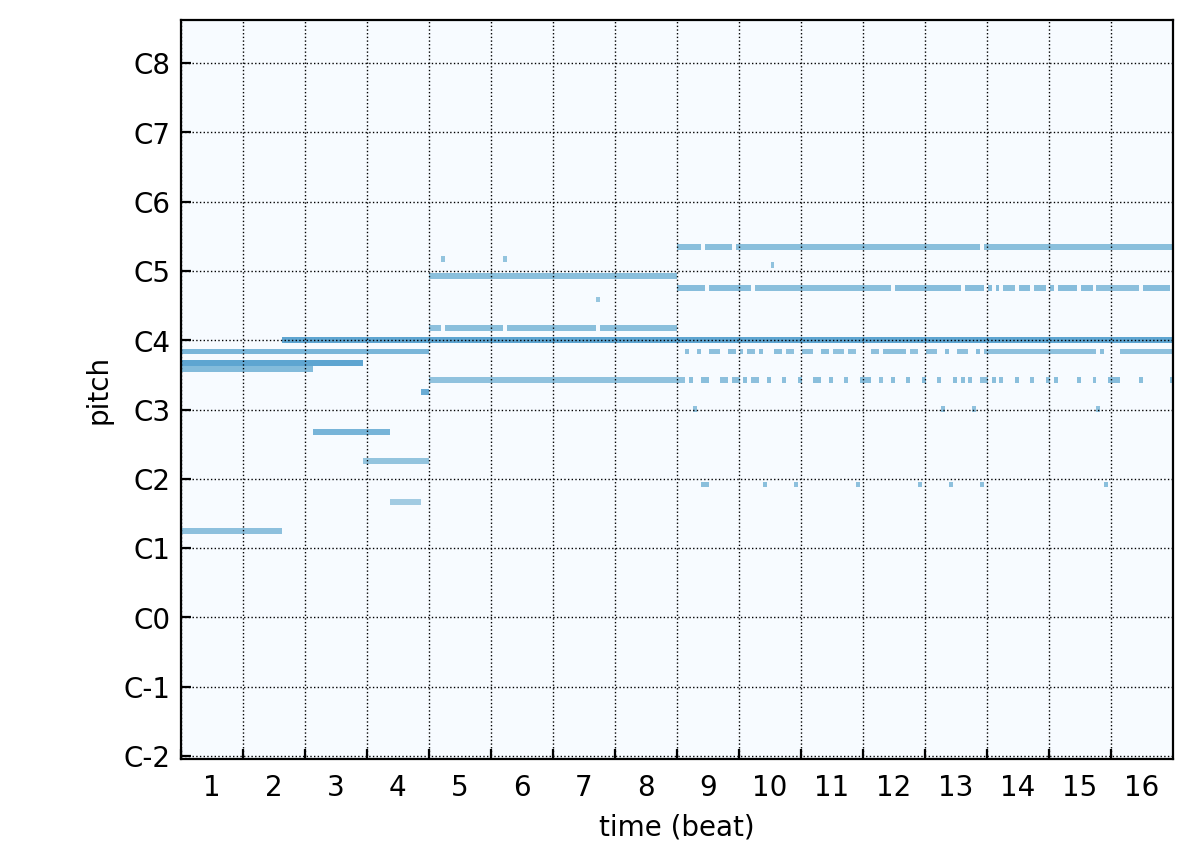

In [11]:
muspy.show_pianoroll(music)

In [12]:
music.write("/scratch/ne2213/projects/DL/DL-FinalProject/GAN/test.mid")